In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.models import model_from_json
import numpy as np
import matplotlib.pyplot as plt
import keras
import pickle

from keras.callbacks import ModelCheckpoint
#!pip install tensorflow tensorflow-gpu tensorflow-io matplotlib

C:\Users\user\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
tf.test.is_built_with_cuda()
tf.config.list_physical_devices('GPU')
#tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=2
CHANNELS=3
print(tf. __version__) 

2.9.1


In [4]:
load_data = tf.keras.preprocessing.image_dataset_from_directory(
    "Newdata",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6524 files belonging to 5 classes.


In [5]:
class_names= load_data.class_names
class_names

['Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Jackfruit___Bacterial_spot',
 'Jackfruit___healthy']

In [6]:
for image_batch,label_batch in load_data.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(2, 256, 256, 3)
[4 4]


In [7]:
len(load_data)

3262

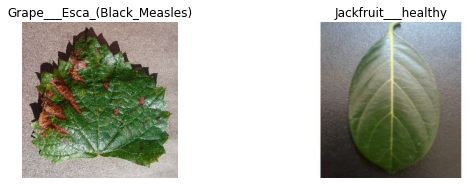

In [8]:
plt.figure(figsize=(20,20))
for image_batch,label_batch in load_data.take(1):
    for i in range(0,2):
        plt.subplot(6,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
def get_dataset_partition_tf(data,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    data_size=len(data)
    if shuffle:
        data=data.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*data_size)
    val_size=int(val_split*data_size)
    train_data=data.take(train_size)
    
    val_data=data.skip(train_size).take(val_size)
    test_data=data.skip(train_size).skip(val_size)
    return train_data,val_data,test_data
    

In [10]:
train_data,val_data,test_data=get_dataset_partition_tf(load_data)

In [11]:
len(train_data)

2609

In [12]:
len(val_data)

326

In [13]:
len(test_data)

327

In [14]:
train_data=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data=val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale =tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255)  

])

In [16]:
data_augmentation =tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)  

])

In [18]:
#for image, _ in train_ds.take(1):
 # plt.figure(figsize=(10, 10))
#  first_image = image[0]
 # for i in range(9):
  #  ax = plt.subplot(3, 3, i + 1)
   # augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    #plt.imshow(augmented_image[0] / 255)
    #plt.axis('off')

In [17]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

overall_model = models.Sequential([
    resize_and_rescale,#data_augmentation,
    layers.Conv2D(16,(3,3),activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,kernel_size = (3,3),activation= "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation= "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(len(class_names),activation='softmax')

])


In [71]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3)

overall_model = models.Sequential([
    resize_and_rescale,data_augmentation,
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [18]:
overall_model.build(input_shape=input_shape)

In [19]:
overall_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (2, 256, 256, 3)          0         
                                                                 
 conv2d (Conv2D)             (2, 254, 254, 16)         448       
                                                                 
 max_pooling2d (MaxPooling2D  (2, 127, 127, 16)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (2, 125, 125, 32)         4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (2, 62, 62, 32)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (2, 60, 60, 64)          

In [20]:
base_learning_rate = 0.0001

overall_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

In [21]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                      min_delta=0.0001,
                                                      patience=5)

In [22]:

history=overall_model.fit(
    train_data,
    epochs=5,
    batch_size=2,
    validation_data=val_data,
    callbacks=[earlystop_callback]

)

Epoch 1/5
2609/2609 [==============================] - 118s 31ms/step - loss: 0.3295 - accuracy: 0.8637 - val_loss: 0.2203 - val_accuracy: 0.9264
Epoch 2/5
2609/2609 [==============================] - 36s 14ms/step - loss: 0.1017 - accuracy: 0.9632 - val_loss: 0.0707 - val_accuracy: 0.9739
Epoch 3/5
2609/2609 [==============================] - 28s 11ms/step - loss: 0.0580 - accuracy: 0.9791 - val_loss: 0.0242 - val_accuracy: 0.9939
Epoch 4/5
2609/2609 [==============================] - 26s 10ms/step - loss: 0.0387 - accuracy: 0.9874 - val_loss: 0.0223 - val_accuracy: 0.9923
Epoch 5/5
2609/2609 [==============================] - 27s 10ms/step - loss: 0.0344 - accuracy: 0.9883 - val_loss: 0.0363 - val_accuracy: 0.9847


In [23]:
scores=overall_model.evaluate(test_data)

327/327 [==============================] - 30s 8ms/step - loss: 0.0585 - accuracy: 0.9801


In [24]:
acc = history.history['accuracy']

test_acc = scores.scores['accuracy']


plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


AttributeError: 'list' object has no attribute 'scores'

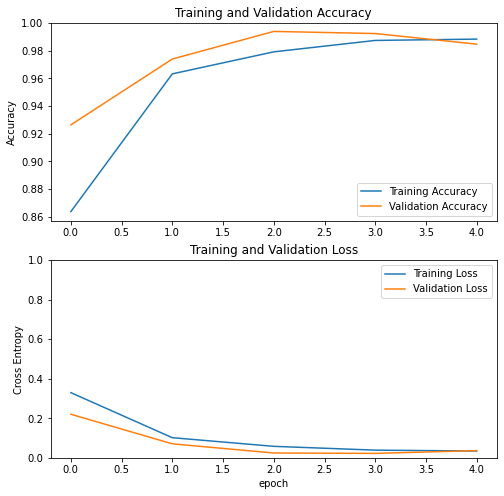

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [58]:
#serial model
model_json = overall_model.to_json()
with open("model.json","w") as json_file:
    json_file.write(model_json)

In [59]:
#serial weight
overall_model.save_weights("model.h5")

In [60]:
#load json model
json_file=open("model.json","r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [61]:
#load weight
loaded_model.load_weights("model.h5")

Actual label :  Jackfruit___Bacterial_spot
1/1 [==============================] - 0s 343ms/step
predicted label :  Jackfruit___Bacterial_spot


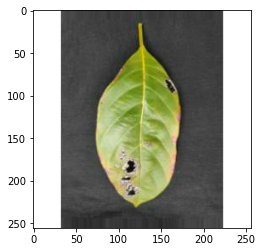

In [26]:
for image_batch,lables_batch in test_data.take(1):
    image=image_batch[0].numpy().astype("uint8")
    label=lables_batch[0].numpy()
    
    plt.imshow(image)
    print("Actual label : ",class_names[label])
    
    batch_prediction=overall_model.predict(image_batch)
    print("predicted label : ",class_names[np.argmax(batch_prediction[0])])

In [27]:
def predict (overall_model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    prediction = overall_model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100*(np.max(prediction[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


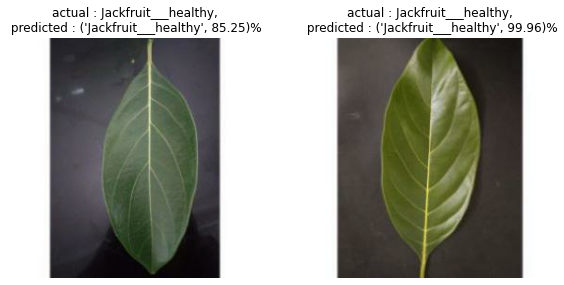

In [28]:
plt.figure(figsize=(15,15))
for image, labels in test_data:
    for i in range(2):
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.subplot(3,3,i+1)
        predicted_class= predict(overall_model,image[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"actual : {actual_class},\n predicted : {predicted_class}%")
        plt.axis("off")

In [ ]:
nvidia-smi

In [64]:
overall_model.save("my_model.h5")

In [ ]:
#tf.__version__
#from tensorflow.keras.preprocessing import image
#from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
#import numpy as np


In [ ]:
#pip install tensorflow==2.9
#baths = "Jackfruit___Bspot_0_29.jpeg"
#img = image.load_img(bath,target_size=(256,256))
#x = image.img_to_array(img)
#x = np.expand_dims(x,axis = 0)
#x = preprocess_input(x)

In [ ]:
#pip uninstall tensorflow
#pred = overall_model.predict(x)

In [ ]:
#pip install --upgrade matplotlib
#pip install --upgrade tensorflow
#print(decode_prediction(pred,top=3)[0])
#print(pred)

In [44]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    "New folder",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE)
)

Found 1 files belonging to 1 classes.


In [43]:
batch_prediction=overall_model.predict(data)
print("predicted label : ",class_names[np.argmax(data)])


1/1 [==============================] - 0s 36ms/step
predicted label :  Grape___Esca_(Black_Measles)


In [45]:
image=data.numpy().astype("uint8")

    
plt.imshow(image)

    
batch_prediction=overall_model.predict(data)
print("predicted label : ",class_names[np.argmax(data)])

AttributeError: 'BatchDataset' object has no attribute 'numpy'

In [51]:
def classify(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)

    #model = tf.keras.applications.resnet50.ResNet50()
    prediction = model.predict(img_preprocessed)

    print(decode_predictions(prediction, top=3)[0])

#classify("rrr.jpg")

In [49]:
import tensorflow as tf

from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [52]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

In [67]:



def load_image(img_path, show=False):

    img = tf.keras.utils.load_img (img_path, target_size=(256, 256))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()
    return img_tensor



In [74]:

if __name__ == "__main__":

    # load model
    model = load_model("my_model.h5")

    # image path
    img_path = 'New folder'   
    #img_path = '/media/data/dogscats/test1/19.jpg'      # cat

    # load a single image
    new_image = load_image(img_path)

    # check prediction
    pred = model.predict(new_image)

PermissionError: [Errno 13] Permission denied: 'New folder'

In [94]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load the image
img_path = r'C://Users//user//345.jpg'
img = load_img(img_path, target_size=(256, 256))

# Convert the image to a numpy array
img_array = img_to_array(img)

# Expand the dimensions of the array to fit the model's input shape
img_array = img_array.reshape((1,) + img_array.shape)

# Load the model
model = load_model('C:/Users/user/my_model.h5')

# Make a prediction on the image
prediction = model.predict(img_array)







1/1 [==============================] - 0s 133ms/step


In [99]:
predicted_label = np.argmax(prediction)

# Map the predicted label to the corresponding class name
class_names = {0: 'Grape___Esca_(Black_Measles)', 1: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 2: 'Grape___healthy',3:'Jackfruit___Bacterial_spot',4:'Jackfruit___healthy' }  # replace with your own class names
predicted_class = class_names[predicted_label]

# Print the predicted class name
print('Predicted class:', predicted_class)

Predicted class: Grape___healthy


In [101]:
Description={"Grape___healthy":"Plant is Healthy",}
des=Description[predicted_class]
des

'qsnjkasj'

In [88]:
import os

img_path = 'Jackfruit___Bspot.jpeg'
if os.path.exists(img_path):
    print("File exists!")
else:
    print("File not found.")


File exists!
